In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import os
from os.path import basename
import re

/home/asha/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
file_names=glob.glob("./all/train/**/*.png")
len(file_names)

4750

In [3]:
file_names[0]

'./all/train/Cleavers/c9576e39e.png'

In [4]:
#get the label from the pathname
y_list=[]
for file_name in file_names:
    y_list.append(re.sub(r'\s', '', file_name).split('/')[3])
y_list=np.array(y_list)


In [5]:
# function to convert labels in to numbers
def names_to_numbers(y_train):
    unq=np.unique(y_train)
    n=len(unq)
    numbers = list(range(0, n))
    y_dict=dict(zip(unq,numbers))
    y_true=[]
    for label in y_train:
        n=y_dict[label]
        y_true.append(n)
    return y_true

In [6]:
labels=names_to_numbers(y_list)

In [7]:
#divide train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( file_names, labels, test_size=0.2)

In [8]:
print len(X_train)
print len(X_test)

3800
950


In [9]:
#function for mapping feartures and labels
def parse_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize_images(image, [224,224])
    
    return image, label

In [10]:
batch_size=32

In [11]:
#creating tensorflow datasets for train data
labels_train=tf.one_hot(y_train,12)
dataset=tf.data.Dataset.from_tensor_slices((X_train,labels_train))
dataset=dataset.map(parse_function)
dataset=dataset.shuffle(buffer_size=100)
dataset=dataset.batch(batch_size)


In [12]:
#iterators for train data
iterator = dataset.make_initializable_iterator()
def train_data():
    x,y = iterator.get_next()
    return x,y

In [13]:
##creating tensorflow datasets for test data
labels_test=tf.one_hot(y_test,12)
dataset_test=tf.data.Dataset.from_tensor_slices((X_test,labels_test))
dataset_test=dataset_test.map(parse_function)
dataset_test=dataset_test.batch(batch_size)

In [14]:
#iterators  for test data
iterator_test = dataset_test.make_initializable_iterator()
def test_data():  
    x,y = iterator_test.get_next()
    return x,y

In [15]:
#boolean to decide train data or test data to the module
a = tf.placeholder(tf.bool)  
x,y= tf.cond(tf.equal(a, tf.constant(True)), lambda:train_data(), lambda:test_data())

In [16]:
conv1=tf.layers.conv2d(x,32,3,strides=1,activation=tf.nn.relu)  
conv1=tf.layers.max_pooling2d(conv1,2,2,padding='SAME')
conv1=tf.layers.batch_normalization(conv1)

    
#convolution, relu and max poling for layer 2
conv2=tf.layers.conv2d(conv1,64,5,strides=1,activation=tf.nn.relu)  
conv2=tf.layers.max_pooling2d(conv2,2,2,padding='SAME')
conv2=tf.layers.batch_normalization(conv2)


#conv3=tf.layers.conv2d(conv2,128,5,strides=1,activation=tf.nn.relu)  
#conv3=tf.layers.max_pooling2d(conv3,2,2,padding='SAME')
#conv3=tf.layers.batch_normalization(conv3)


fc1=tf.contrib.layers.flatten(conv2)
#fully connected layer
fc1=tf.layers.dense(inputs=fc1, units=1024,activation=tf.nn.relu)
fc2=tf.layers.dense(inputs=fc1, units=512,activation=tf.nn.relu)
logits=tf.layers.dense(inputs=fc2, units=12)
#softmax for probabilities
#prob=tf.nn.softmax(logits)
    
#calculating loss
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss_op)
    
#calculating accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
init=tf.global_variables_initializer()

In [18]:
batches=len(X_train)/batch_size
batches=int(batches)
epochs=7
print batches
batches_test=len(X_test)/batch_size
print batches_test

118
29


In [19]:

loss_train=[]
accuracy_train=[]

loss_val=[]
accuracy_val=[]

loss_test=[]
accuracy_test=[]

In [20]:
with tf.Session() as sess:
    sess.run(init)
    sess.run(iterator_test.initializer)  
    for epoch in range(epochs):
        sess.run(iterator.initializer)
        print "Epoch:",epoch ,"running"
        for batch in range(batches):
            loss,acc,_=sess.run([loss_op,accuracy,train_op],feed_dict={a:True})
            accuracy_train.append(acc)
            loss_train.append(loss)
            if batch%50==0:
                print "batch",batch,"loss:",loss,"accuracy",acc
                sess.run(iterator_test.initializer) 
                l_v,acc_v=sess.run([loss_op,accuracy],feed_dict={a:False})
                accuracy_val.append(acc_v)
                loss_val.append(l_v)
                print "validation data loss",l_v,"accuracy",acc_v
                     
        print "Epoch:",epoch,"ended"
    print "optimazion finished"
    
    print "Model running on test data "
    sess.run(iterator_test.initializer)
    for batch in range(batches_test):
        l_t,acc_t=sess.run([loss_op,accuracy],feed_dict={a:False})
        accuracy_test.append(acc_t)
        loss_test.append(l_t)
        
    n=sum(accuracy_test)/len(accuracy_test)
    print "Accuracy for testing data:",n
    
      
   

Epoch: 0 running
batch 0 loss: 2.516499 accuracy 0.0
validation data loss 2.5368552 accuracy 0.125
batch 50 loss: 1.9895718 accuracy 0.4375
validation data loss 1.8665967 accuracy 0.4375
batch 100 loss: 1.5999887 accuracy 0.375
validation data loss 1.4597654 accuracy 0.53125
Epoch: 0 ended
Epoch: 1 running
batch 0 loss: 1.4252964 accuracy 0.5625
validation data loss 1.3145301 accuracy 0.5625
batch 50 loss: 1.0114232 accuracy 0.5625
validation data loss 1.224055 accuracy 0.5625
batch 100 loss: 0.8715937 accuracy 0.75
validation data loss 1.1480889 accuracy 0.59375
Epoch: 1 ended
Epoch: 2 running
batch 0 loss: 0.90140057 accuracy 0.71875
validation data loss 1.1163316 accuracy 0.53125
batch 50 loss: 0.59741604 accuracy 0.875
validation data loss 1.0218728 accuracy 0.59375
batch 100 loss: 0.72936416 accuracy 0.75
validation data loss 0.9656076 accuracy 0.71875
Epoch: 2 ended
Epoch: 3 running
batch 0 loss: 0.74706256 accuracy 0.75
validation data loss 0.9118138 accuracy 0.6875
batch 50 los

In [21]:
import matplotlib.pyplot as plt

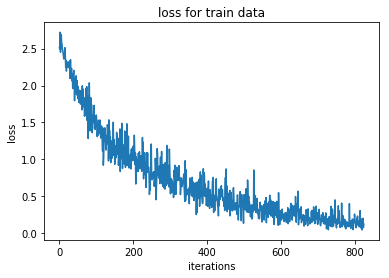

In [22]:


fig, ax = plt.subplots()
ax.set_xlabel("iterations")
ax.set_ylabel(r"loss")
ax.plot(loss_train)
ax.set_title("loss for train data")
plt.show()


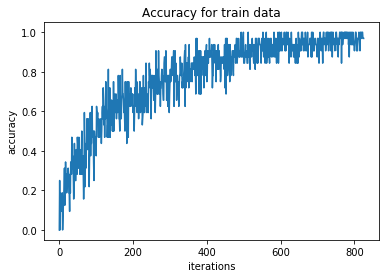

In [23]:

fig, ax = plt.subplots()
ax.set_xlabel("iterations")
ax.set_ylabel(r"accuracy")
ax.plot(accuracy_train)
ax.set_title("Accuracy for train data")
plt.show()


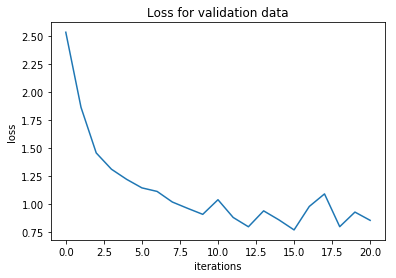

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("iterations")
ax.set_ylabel(r"loss")
ax.plot(loss_val)
ax.set_title("Loss for validation data")
plt.show()


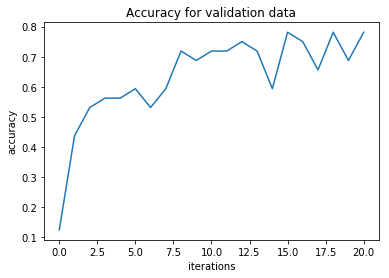

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("iterations")
ax.set_ylabel(r"accuracy")
ax.plot(accuracy_val)
ax.set_title("Accuracy for validation data")
plt.show()